# The Frequency Domain

* The frequency domain is a mathematical concept used in signal processing and analysis, including fields such as physics, engineering, and telecommunications. In the frequency domain, signals are represented in terms of their frequency components, revealing how much of the signal's total energy is associated with each frequency.
* Contrasting with the time domain, where signals are represented as functions of time, the frequency domain provides information about the frequency content of a signal. The transformation between the time domain and the frequency domain is often achieved through mathematical tools like the Fourier Transform.
## Concepts:

* **Frequency**: It represents the number of cycles of a periodic waveform that occur in a unit of time. Frequency is measured in Hertz (Hz), where 1 Hz is equivalent to one cycle per second.
* **Fourier Transform**: This mathematical transformation is a key tool for converting a signal from the time domain to the frequency domain. It breaks down a complex signal into its individual frequency components, revealing the amplitude and phase information associated with each frequency.
* **Spectrum**: The frequency spectrum of a signal represents the distribution of its energy across different frequencies. It is often displayed as a plot, with frequency on the x-axis and amplitude or power on the y-axis.
* **Frequency Analysis**: By analyzing a signal in the frequency domain, one can identify specific frequencies or frequency ranges that contribute significantly to the signal. This is valuable for understanding the characteristics of the signal and extracting relevant information.
* **Filters**: In signal processing, filters are used to modify the frequency content of a signal. Filters can selectively pass or attenuate certain frequencies, allowing engineers to tailor signals to specific requirements.

**In the context of gravitational wave analysis, the frequency domain is crucial for studying the characteristics of gravitational wave signals. When gravitational waves from astrophysical events are detected, their frequency content provides essential information about the nature of the source, such as the masses of the objects involved and the dynamics of their interaction. Analyzing signals in the frequency domain allows researchers to extract meaningful insights and interpret the astrophysical phenomena that give rise to gravitational waves.**

# Libraries

In [1]:
%%capture
!pip install gwpy
!pip install gwosc # provides an interface to querying the open data releases hosted on https://gwosc.org
!pip install h5py

In [220]:
from gwpy.timeseries import TimeSeries,TimeSeriesDict
from gwpy.segments import Segment
from gwpy.signal import filter_design
from gwpy.plot import Plot

In [221]:
from gwosc import datasets

In [3]:
from scipy import signal
from scipy.io import wavfile
from copy import deepcopy
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
plt.style.use("dark_background")
%matplotlib inline

# Functions For Example Wave & Noise

In [4]:
def MakeWhiteNoise(fsRate:int or float,timeInterval:int or float)->list:
  # sample_rate: in samples per second (Hertz)
  # size: Number of elements in the array
  # unit: The physical unit of these data
  noise = TimeSeries(random.normal(scale=.1,size=fsRate*timeInterval),sample_rate=fsRate,unit='nm')
  return noise

In [5]:
def SinusoidalSignal(fsRate:int or float,timeInterval:list)->list:
  signal = np.sin(2*np.pi*fsRate*timeInterval)
  return signal

In [6]:
def FourierTransform(signal:list,fsRate:int or float)->list:
  fftResult = np.fft.fft(signal)
  frequencies = np.fft.fftfreq(len(fftResult),1/fsRate)
  return frequencies,fftResult

# Plot Wave & Noise

**This example creates a simple sinusoidal signal in the time domain with a frequency of 5 Hz. The script then performs a Fourier Transform on the signal, and the resulting frequency spectrum is plotted.**

In [7]:
samplingFrequency = 1000 # Sampling frequency
timeInterval = np.linspace(0,1,endpoint=True) # Time array from 0 to 1 second
frequency = 5 # Frequency of the signal in Hertz

In [8]:
signal = SinusoidalSignal(frequency,timeInterval) # A simple sinusoidal signal

In [9]:
# Perform Fourier Transform to convert to frequency domain
frequencies,fftResult = FourierTransform(signal,samplingFrequency)

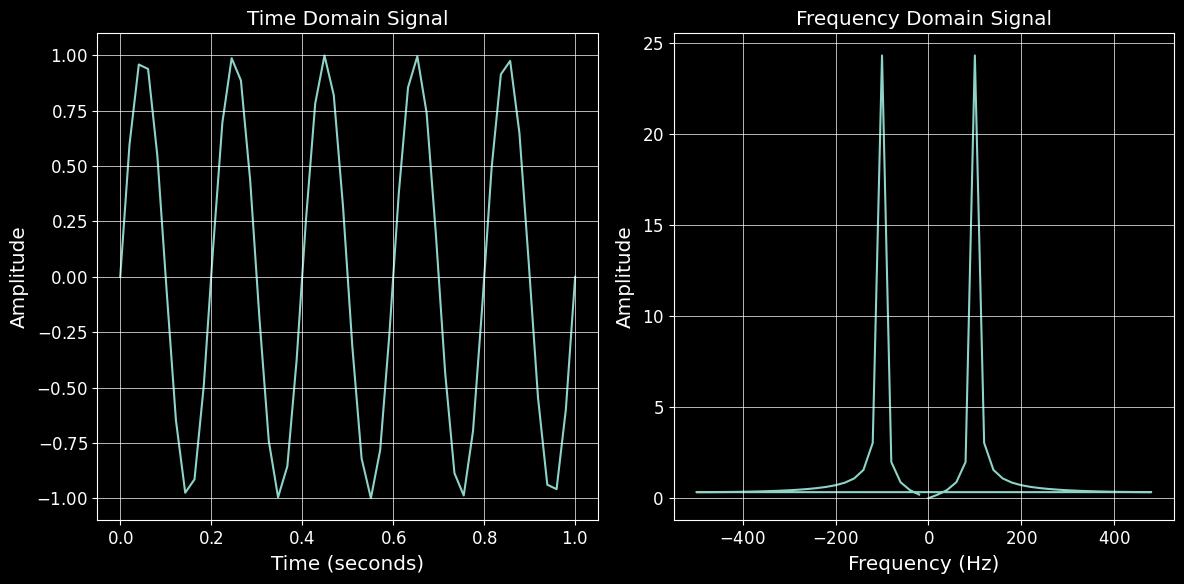

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Time Domain Signal")
plt.plot(timeInterval,signal)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.subplot(122)
plt.title("Frequency Domain Signal")
plt.plot(frequencies,np.abs(fftResult))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# White Noise

* White noise is a random signal with equal intensity at different frequencies, giving it a constant power spectral density. It is characterized by a flat frequency spectrum, meaning that all frequencies have an equal amount of energy. White noise is often used in signal processing and experiments as a reference or to mask other sounds.

**Properties**: Because of its uniform frequency spectrum, white noise contains energy at all frequencies, providing a broad and constant signal. This characteristic makes it valuable in areas such as signal processing, communications, and system identification.

**White noise is suitable for scenarios requiring a flat frequency spectrum and equal energy at all frequencies.**

In [11]:
samplingFrequency = 32000
noiseStep = 8

In [12]:
noise = MakeWhiteNoise(samplingFrequency,noiseStep)
noiseFrequencyFFT = noise.fft()

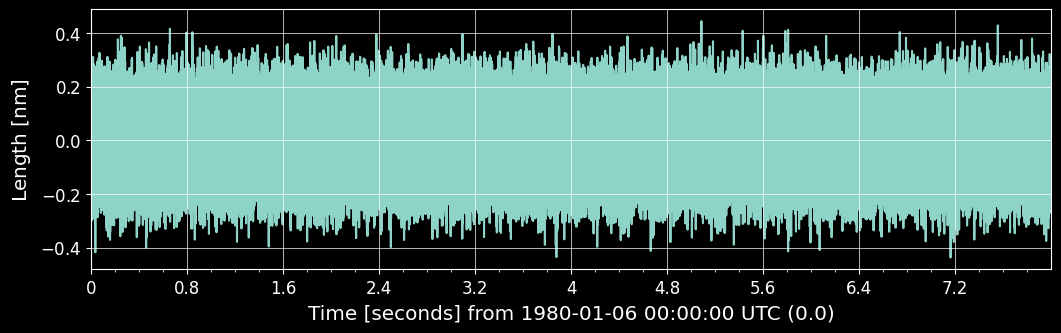

In [13]:
plotNoise = noise.plot()
plotNoise.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


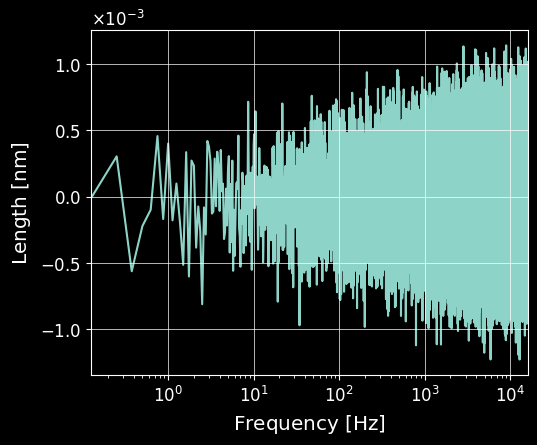

In [14]:
plotFFT = noiseFrequencyFFT.plot()
plotFFT.show()

# Red Noise (Brownian Noise)

* Red noise, also known as Brownian noise or random walk, is a type of stochastic process where each value is generated by adding a random increment. Unlike white noise, red noise exhibits a correlation between successive values, leading to a characteristic decrease in power at higher frequencies. It has a spectrum that tilts towards lower frequencies, giving it a "reddish" appearance when visualized.

**Properties**: The correlation between successive values in red noise gives it a longer-term memory compared to white noise. This property is useful in simulating processes with persistence or trends. In fields like climate science, ecology, and geophysics, red noise is employed to capture the autocorrelation seen in real-world data.

**Red noise, with its correlation between values, is more applicable in situations where persistence and memory effects are important, reflecting certain natural processes more accurately.**

In [15]:
def GenerateRedNoise(length:int or float,betaValue:int=1)->list:
  """
    Generate red noise using a random walk process.

    Parameters:
    - length: Length of the generated signal.
    - beta: Exponent controlling the spectral slope (default is 1 for standard red noise).

    Returns:
    - redNoise: Generated red noise signal.
  """
  whiteNoise = np.random.normal(0,1,length)
  redNoise = np.cumsum(whiteNoise) # Cumulative sum to create a random walk
  redNoise -= np.linspace(0,betaValue,length) # Applying the spectral slope
  return redNoise

In [16]:
lengthofSignal = 1000

In [17]:
redNoise = GenerateRedNoise(length=lengthofSignal)

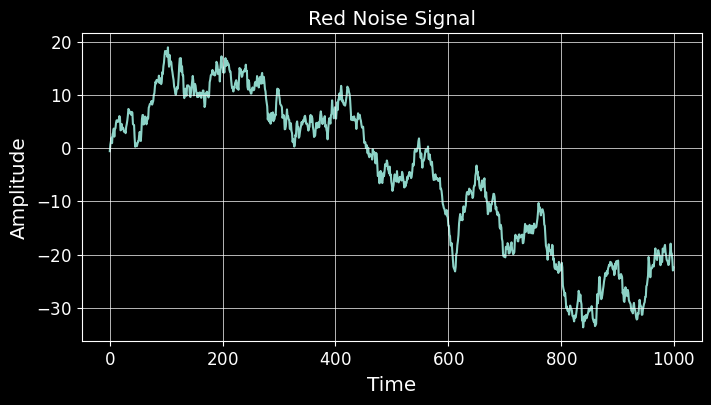

In [18]:
# Plot the red noise signal
plt.figure(figsize=(8, 4))
plt.plot(redNoise)
plt.title('Red Noise Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

**In astronomy, red noise or correlated noise models are often used to simulate various sources of systematic errors or intrinsic variability in observational data. One common application is in the analysis of light curves, where astronomers study the variations in brightness of celestial objects over time.**

In [19]:
def GenerateRedNoise(length:int or float,betaValue:int=1)->list:
  """
    Generate red noise using a random walk process.

    Parameters:
    - length: Length of the signal.
    - betaValue: Exponent controlling the spectral slope (default is 1 for standard red noise).

    Returns:
    - red_noise: Generated red noise signal.
  """
  whiteNoise = random.normal(0,1,length)
  redNoise = np.cumsum(whiteNoise) # Cumulative sum to create a random walk
  redNoise -= np.linspace(0,betaValue,length) # Applying the spectral slope
  return redNoise


In [20]:
def GenerateRedNoiseLightCurve(length:int or float,betaValue:int=1,amplitude:int=1,timeStep:int=1)->tuple:
  """
    Generate a red noise light curve.

    Parameters:
    - length: Length of the light curve.
    - betaValue: Exponent controlling the spectral slope (default is 1 for standard red noise).
    - amplitude: Amplitude of the variations.
    - timeStep: Time step between observations.

    Returns:
    - timeInterval: Time array.
    - flux: Simulated light curve.
  """
  timeInterval = np.arange(0,length*timeStep,timeStep)
  whiteNoise = random.normal(0,1,length)
  redNoise = amplitude*GenerateRedNoise(length,betaValue)
  flux = whiteNoise+redNoise
  return timeInterval,flux

In [21]:
length = 500 # Length of the light curve
beta = 1.5 # Exponent controlling the spectral slope
amplitude = 0.5 # Amplitude of the variations
timeStep = 1 # Time step between observations

In [22]:
timeInterval,flux = GenerateRedNoiseLightCurve(length,beta,amplitude,timeStep)

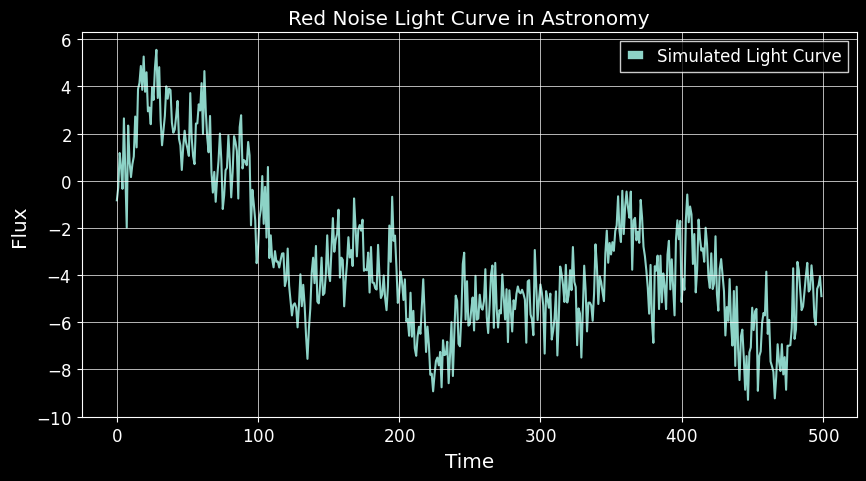

In [23]:
plt.figure(figsize=(10,5))
plt.plot(timeInterval,flux,label="Simulated Light Curve")
plt.title("Red Noise Light Curve in Astronomy")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

# LIGO - External Data Source Example

In [24]:
%%capture
!wget https://www.gw-openscience.org/s/events/GW150914/L-L1_LOSC_4_V1-1126259446-32.hdf5

In [25]:
filePath = "/content/L-L1_LOSC_4_V1-1126259446-32.hdf5"

In [26]:
strainData = TimeSeries.read(filePath,format="hdf5.gwosc")

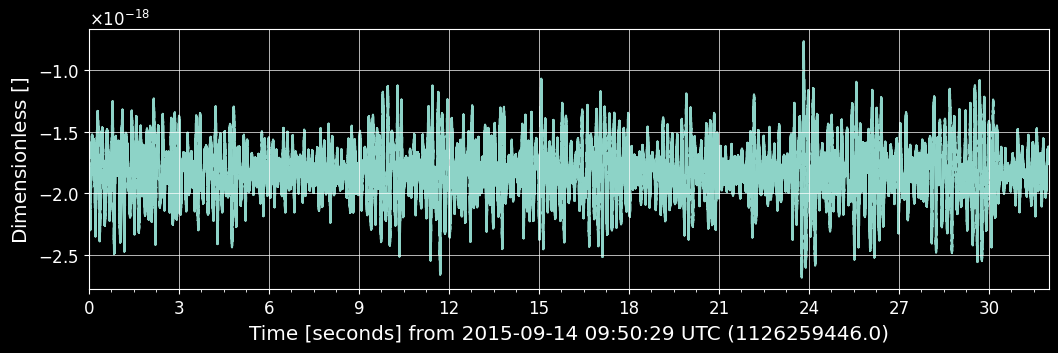

In [27]:
strainPlot = strainData.plot()
strainPlot.show()

# LIGO - Internal Data Source Example

In [40]:
def ConvertGPSTimetoISO(gpsTime:int or float)->str:
  # GPS time starts from January 6, 1980
  gpsEpoch = datetime(1980,1,6,0,0,0)
  # Add GPS time to GPS epoch
  UTCDatetime = gpsEpoch+timedelta(seconds=gpsTime)
  iso = UTCDatetime.strftime("%Y-%m-%dT%H:%M:%S")
  return iso

In [41]:
def ConvertISOtoGPSTime(isoTime:str)->int or float:
  # Convert ISO8601 string to datetime object
  utcDatetime = datetime.fromisoformat(isoTime.replace("Z","+00:00"))
  # GPS time starts from January 6, 1980, and there were 19 leap seconds until 2022
  gpsEpoch = datetime(1980,1,6,0,0,0)+timedelta(seconds=19)
  # Calculate the time difference between UTC and GPS time
  timeDifference = utcDatetime-gpsEpoch
  gpsTime = timeDifference.total_seconds()
  return gpsTime

In [42]:
detectorExample = "L1"

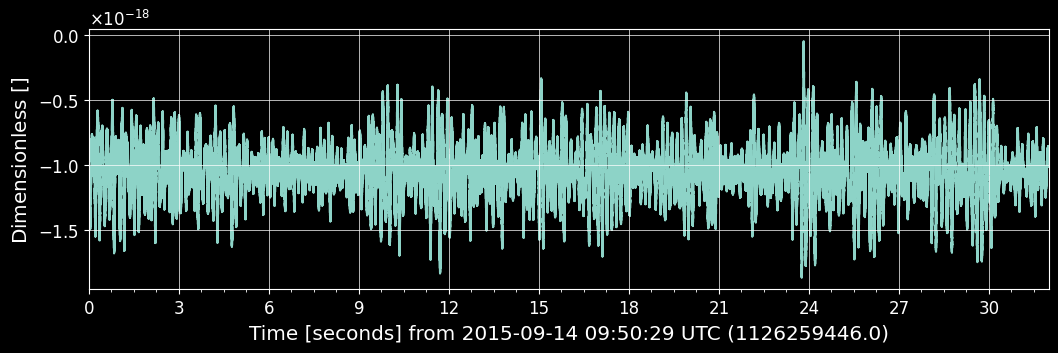

In [43]:
l1OpenData = TimeSeries.fetch_open_data(detectorExample,"Sep 14 2015 09:50:29","Sep 14 2015 09:51:01")
l1Plot = l1OpenData.plot()
l1Plot.show()

In [44]:
epochGPS = 1126259462
epochISO = ConvertGPSTimetoISO(epochGPS)
print(f"Epoch GPS: {epochGPS}\nEpoch ISO: {epochISO}")

Epoch GPS: 1126259462
Epoch ISO: 2015-09-14T09:51:02


In [45]:
ax = l1Plot.gca()
ax.set_ylabel("Gravitational-wave amplitude [strain]")
ax.set_epoch(epochGPS)
ax.set_title("LIGO-Livingston strain data around GW150914")
ax.axvline(epochGPS,color="green",linestyle="--")
l1Plot.refresh()
l1Plot.show()

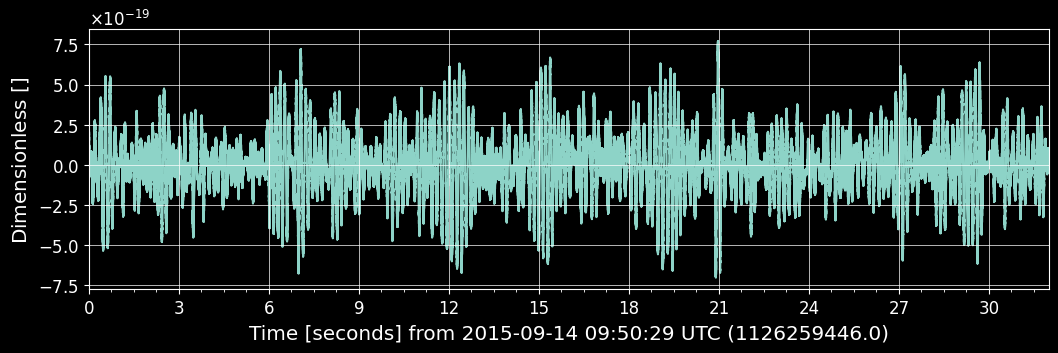

In [46]:
h1OpenData = TimeSeries.fetch_open_data("H1","Sep 14 2015 09:50:29","Sep 14 2015 09:51:01")
h1Plot = h1OpenData.plot()
h1Plot.show()

In [47]:
combinedDataStrain = TimeSeriesDict()
combinedDataStrain["H1"] = h1OpenData
combinedDataStrain["L1"] = l1OpenData

In [48]:
combinedDataStrain

TimeSeriesDict([('H1',
                 <TimeSeries([2.17704028e-19, 2.08763900e-19, 2.39681183e-19, ...,
                              3.55365541e-20, 6.33533516e-20, 7.58121195e-20]
                             unit=Unit(dimensionless),
                             t0=<Quantity 1.12625945e+09 s>,
                             dt=<Quantity 0.00024414 s>,
                             name='Strain',
                             channel=None)>),
                ('L1',
                 <TimeSeries([-1.04289994e-18, -1.03586274e-18, -9.89322445e-19,
                              ..., -1.01767748e-18, -9.82876816e-19,
                              -9.59276974e-19]
                             unit=Unit(dimensionless),
                             t0=<Quantity 1.12625945e+09 s>,
                             dt=<Quantity 0.00024414 s>,
                             name='Strain',
                             channel=None)>)])

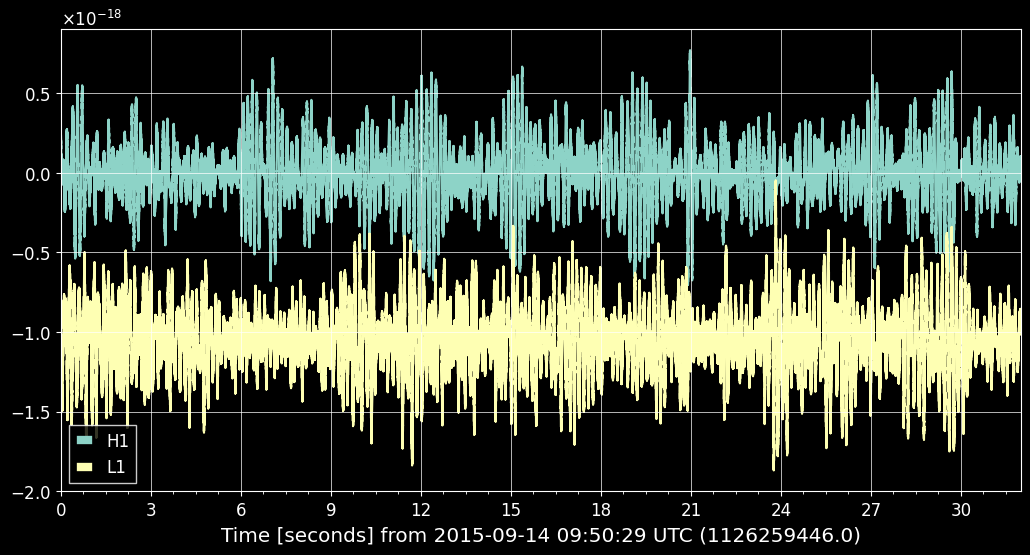

In [49]:
combinedPlot = combinedDataStrain.plot()
combinedPlot.gca().legend()
combinedPlot.show()

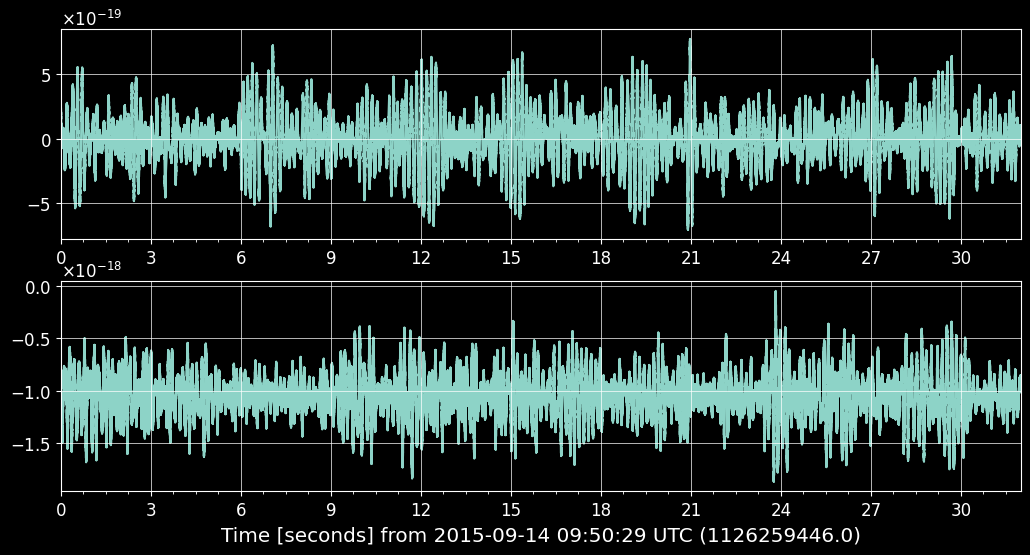

In [50]:
# another method of achieving the same result is by importing and accessing the Plot object directly
plotBase = Plot(h1OpenData,l1OpenData,separate=True,sharex=True)
plotBase.show()

# Data Reading With HDF5

In [56]:
!wget -q -N https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126257414-4096.hdf5
!wget -q -N https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126257414-4096.hdf5

In [51]:
import h5py

In [69]:
dataExampleFiles = {"GW150914":"LOSC_4_V2-1126257414-4096.hdf5"}
H1DetectorData = "/content/"+"H-H1_"+dataExampleFiles["GW150914"]
L1DetectorData = "/content/"+"L-L1_"+dataExampleFiles["GW150914"]

In [70]:
GPSTimeCenter = 1126259462 # the approximate event time

In [156]:
dataFile = h5py.File(L1DetectorData)

In [157]:
print(f"Data Name: {dataFile.name}")

Data Name: /


In [158]:
fileKeys = list(dataFile.keys())
print(f"Key:\n{fileKeys}")

Key:
['meta', 'quality', 'strain']


In [159]:
fileItems = list(dataFile.items())
print(f"Items:\n\n{fileItems}")

Items:

[('meta', <HDF5 group "/meta" (8 members)>), ('quality', <HDF5 group "/quality" (3 members)>), ('strain', <HDF5 group "/strain" (1 members)>)]


In [160]:
metaData = dataFile["meta"]
metaDataAttributes = list(metaData)
print(f"Metadata File: {metaData.file}")
print(f"Metadata ID: {metaData.id}\n")
print(f"Metadata Attributes:\n\n{metaDataAttributes}")

Metadata File: <HDF5 file "L-L1_LOSC_4_V2-1126257414-4096.hdf5" (mode r)>
Metadata ID: <h5py.h5g.GroupID object at 0x7bc006113420>

Metadata Attributes:

['Description', 'DescriptionURL', 'Detector', 'Duration', 'GPSstart', 'Observatory', 'Type', 'UTCstart']


In [161]:
desriptionURL = metaData["DescriptionURL"]
desription = metaData["Description"]
GPSstart = metaData["GPSstart"]
observatory = metaData["Observatory"]
detector = metaData["Detector"]
print(f"Description URL: {list(desriptionURL.attrs)} - Shape: {desriptionURL.shape}")
print(f"Description: {list(desription.attrs)} - Shape: {desription.shape}")
print(f"GPS Start: {list(GPSstart.attrs)} - Shape: {GPSstart.shape}")
print(f"Observatory: {list(observatory.attrs)} - Shape: {observatory.shape}")
print(f"Detector: {list(detector.attrs)} - Shape: {detector.shape}")

Description URL: [] - Shape: ()
Description: [] - Shape: ()
GPS Start: [] - Shape: ()
Observatory: [] - Shape: ()
Detector: [] - Shape: ()


In [162]:
strainData = dataFile["strain"]
strainDataAttributes = list(strainData)
print(f"Strain Data:\n{strainData}")
print(f"Strain Data Attributes:\n{strainDataAttributes}")

Strain Data:
<HDF5 group "/strain" (1 members)>
Strain Data Attributes:
['Strain']


In [163]:
strainMain = strainData["Strain"]
print(f"Strain Raw Shape: {strainMain.shape}")
print(f"Strain Raw Data Attributes:\n{list(strainMain.attrs)}")

Strain Raw Shape: (16777216,)
Strain Raw Data Attributes:
['Npoints', 'Xlabel', 'Xspacing', 'Xstart', 'Xunits', 'Ylabel', 'Yunits']


In [164]:
Xspacing = strainMain.attrs["Xspacing"]
Xlabel = strainMain.attrs["Xlabel"]
Xunits = strainMain.attrs["Xunits"]
Ylabel = strainMain.attrs["Ylabel"]
Yunits = strainMain.attrs["Yunits"]
Npoints = strainMain.attrs["Npoints"]
print(f"Xspacing: {Xspacing}")
print(f"Xlabel: {Xlabel}")
print(f"Xunits: {Xunits}")
print(f"Ylabel: {Ylabel}")
print(f"Yunits: {Yunits}")
print(f"Npoints: {Npoints}")

Xspacing: 0.000244140625
Xlabel: GPS time
Xunits: second
Ylabel: Strain
Yunits: 
Npoints: 16777216


In [165]:
sampleRate = int(1.0/Xspacing)
print(f"Sample Rate: {sampleRate} Hz in file {L1DetectorData}")

Sample Rate: 4096 Hz in file /content/L-L1_LOSC_4_V2-1126257414-4096.hdf5


# Filtering

## Sample Example

In [166]:
filePath = "/content/L-L1_LOSC_4_V1-1126259446-32.hdf5"

In [167]:
baseData = TimeSeries.read(filePath,format="hdf5.gwosc")

In [177]:
def AnalyzeLIGO(datasetBase:list or np.ndarray)->None:
  # Apply a bandpass filter to focus on gravitational wave frequencies
  flow = 30 # lower corner frequency of pass band
  fHigh = 250 # upper corner frequency of pass band
  bandpass = filter_design.bandpass(flow,fHigh,datasetBase.sample_rate)
  bandpassData = datasetBase.filter(bandpass,filtfilt=True)
  plt.figure(figsize=(12,6))
  plt.subplot(2,1,1)
  plt.plot(datasetBase,label="RAW")
  plt.title("LIGO Gravitational Wave Data - RAW")
  plt.xlabel("GPS Time (s)")
  plt.ylabel("Strain")
  plt.subplot(2,1,2)
  plt.plot(bandpassData,label="Band-Pass")
  plt.xlabel("GPS Time (s)")
  plt.ylabel("Strain")
  plt.legend()
  plt.show()

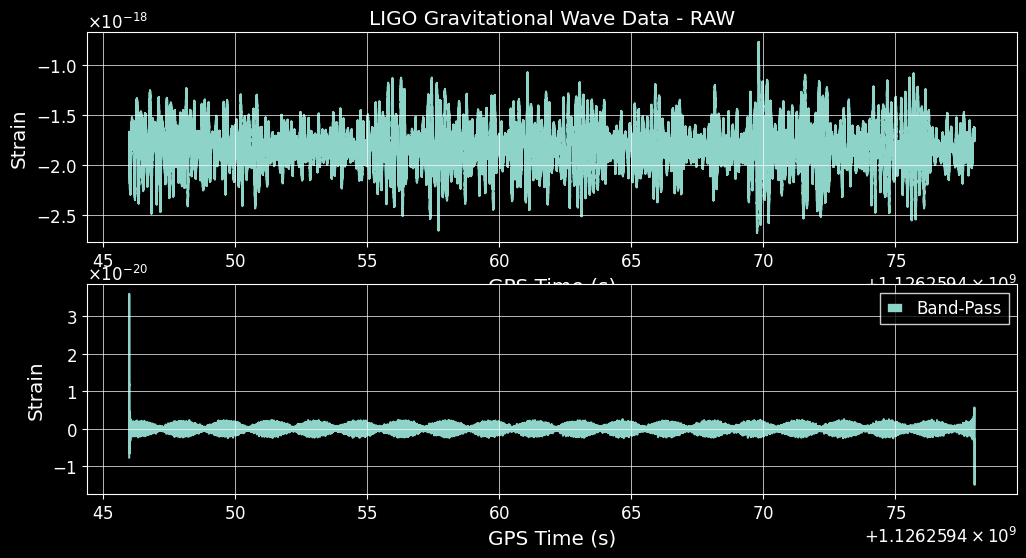

In [178]:
AnalyzeLIGO(baseData)

## Gravitational Wave Example

In [180]:
GPSStartTime,ISOStartTime = 1126259446,ConvertGPSTimetoISO(1126259446)
GPSEndTime,ISOEndTime = 1126259478,ConvertGPSTimetoISO(1126259478)
print(f"Start Time: {ISOStartTime}")
print(f"End Time: {ISOEndTime}")

Start Time: 2015-09-14T09:50:46
End Time: 2015-09-14T09:51:18


In [200]:
flow = 50 # lower corner frequency of pass band
fHigh = 250 # upper corner frequency of pass band

In [212]:
hfData = TimeSeries.fetch_open_data("H1",GPSStartTime,GPSEndTime)

In [213]:
print(f"Sample Rate: {hfData.sample_rate}")

Sample Rate: 4096.0 Hz


**A notch filter is a type of signal processing filter designed to attenuate or suppress a specific narrow range of frequencies while allowing all other frequencies to pass through relatively unaffected.**

**The "zpk" representation is a way to represent a transfer function in control theory and signal processing. In this representation, a transfer function is expressed in terms of its zeros (Z), poles (P), and a constant gain (K). The zeros and poles are complex numbers that define the locations in the complex plane where the transfer function becomes zero or infinite, respectively.**

**Zeros (Z)**: The points in the complex plane where the transfer function becomes zero.

**Poles (P)**: The points in the complex plane where the transfer function becomes infinite.

**Gain (K)**: A constant multiplier that scales the entire transfer function.

**In the context of filters, including notch filters, the zpk representation is commonly used to define the transfer function of the filter. Engineers and researchers can manipulate the positions of zeros and poles to design filters with specific characteristics, such as frequency response and damping.**

In [214]:
bandpass = filter_design.bandpass(flow,fHigh,hfData.sample_rate)
# for the first three harmonics of the 60 Hz AC mains power
notches = [filter_design.notch(lineBase,hfData.sample_rate) for lineBase in (60,120,180)]

In [215]:
zpk = filter_design.concatenate_zpks(bandpass,*notches)

In [216]:
dataFilter = hfData.filter(zpk,filtfilt=True)

In [204]:
print(f"Filter Data Time-Span: {dataFilter.span}")
print(f"Main Data Time-Span: {hfData.span}")

Filter Data Time-Span: [1126259446.0 ... 1126259478.0)
Main Data Time-Span: [1126259446.0 ... 1126259478.0)


In [205]:
hfDataMain = hfData.crop(*hfData.span.contract(1))
hfilterMain = dataFilter.crop(*dataFilter.span.contract(1))

In [206]:
print(f"Filter Data Time-Span (Crop): {hfilterMain.span}")
print(f"Main Data Time-Span (Crop): {hfDataMain.span}")

Filter Data Time-Span (Crop): [1126259447.0 ... 1126259477.0)
Main Data Time-Span (Crop): [1126259447.0 ... 1126259477.0)


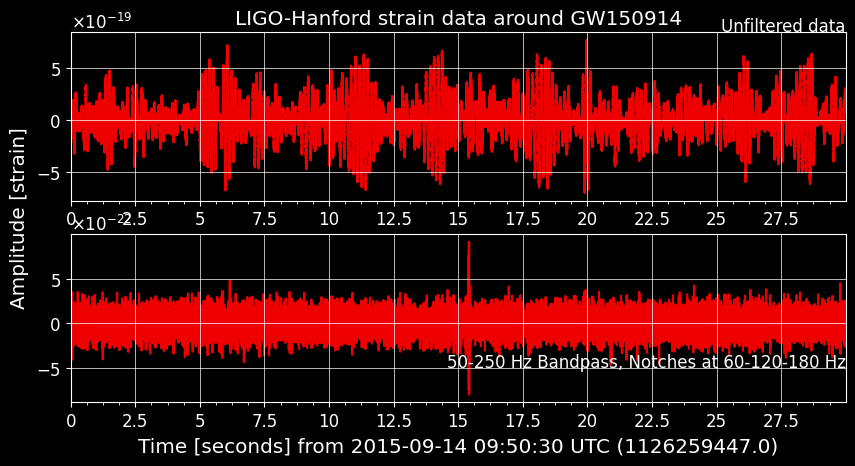

In [208]:
plotData = Plot(hfDataMain,hfilterMain,figsize=[10,5],separate=True,sharex=True,color="gwpy:ligo-hanford")
axs1,axs2 = plotData.axes
axs1.set_title("LIGO-Hanford strain data around GW150914")
axs1.set_ylabel("Amplitude [strain]",y=-0.1)
axs1.text(1.0,1.01,"Unfiltered data",transform=axs1.transAxes,ha="right")
axs2.set_ylabel("")
axs2.text(1.0,0.21,f"{flow}-{fHigh} Hz Bandpass, Notches at 60-120-180 Hz",transform=axs2.transAxes,ha="right")
plotData.show()

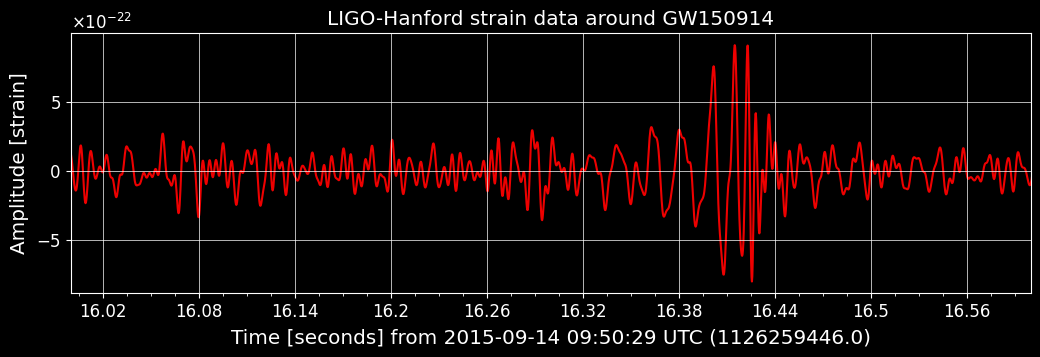

In [210]:
plotHfilter = hfilterMain.plot(color="gwpy:ligo-hanford")
ax = plotHfilter.gca()
ax.set_title("LIGO-Hanford strain data around GW150914")
ax.set_ylabel("Amplitude [strain]")
ax.set_xlim(1126259462,1126259462.6)
ax.set_xscale("seconds",epoch=1126259446)
plotHfilter.show()

**The detector told us that the signals were separated by 6.9 ms between detectors, and that the relative orientation of those detectors means that we need to invert the data from one before comparing them**

In [217]:
Ldata = TimeSeries.fetch_open_data("L1",GPSStartTime,GPSEndTime)
LFilter = Ldata.filter(zpk,filtfilt=True)

In [218]:
LFilter.shift("6.9ms")
LFilter *= -1

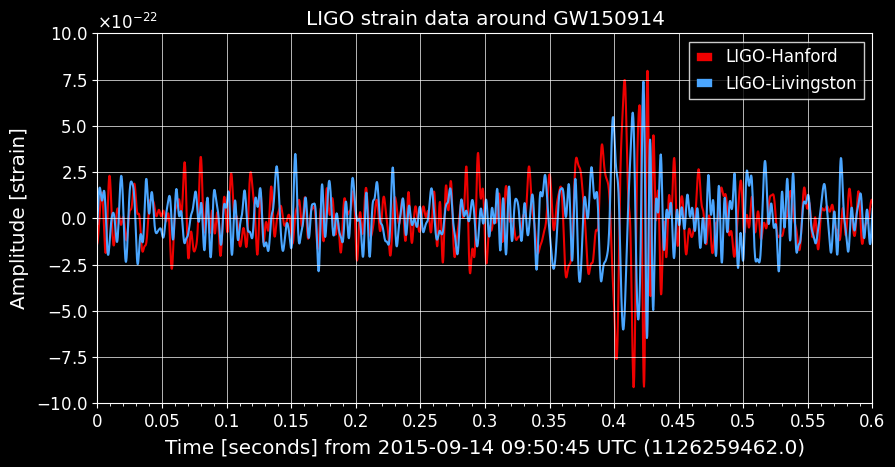

In [219]:
plotMain = Plot(figsize=[10,5])
ax = plotMain.gca()
ax.plot(hfilterMain,label="LIGO-Hanford",color="gwpy:ligo-hanford")
ax.plot(LFilter,label="LIGO-Livingston",color="gwpy:ligo-livingston")
ax.set_title("LIGO strain data around GW150914")
ax.set_xlim(1126259462,1126259462.6)
ax.set_xscale("seconds",epoch=1126259462)
ax.set_ylabel("Amplitude [strain]")
ax.set_ylim(-1e-21,1e-21)
ax.legend()
plotMain.show()

**Below we use this algorithm to visualise GW170817, a gravitational-wave signal from two merging neutron stars. In the LIGO-Livingston (L1) detector, the end of this signal coincides with a very loud glitch.**

In [230]:
from matplotlib import colormaps

In [223]:
GPSGW = datasets.event_gps("GW170817")
print(f"GW170817-Center GPS Time:\n{GPSGW}")

GW170817-Center GPS Time:
1187008882.4


In [224]:
dataGW = TimeSeries.fetch_open_data("L1",GPSGW-34,GPSGW+34)

In [226]:
segmentData = dataGW.q_gram(
    qrange=(4,150),
    search=Segment(GPSGW-0.25,GPSGW+0.25),
    mismatch=0.35
)

In [227]:
segmentData

time,frequency,duration,bandwidth,energy
float64,float64,float64,float64,float64
1187008879.7436523,11.235294117647058,0.53125,0.4176880278369133,35.49808120727539
1187008880.2749023,11.235294117647058,0.53125,0.4176880278369133,183.91539001464844
1187008880.8061523,11.235294117647058,0.53125,0.4176880278369133,431.2776794433594
1187008881.3374023,11.235294117647058,0.53125,0.4176880278369133,576.4652099609375
1187008881.8686523,11.235294117647058,0.53125,0.4176880278369133,465.0181884765625
1187008882.3999023,11.235294117647058,0.53125,0.4176880278369133,217.65969848632812
1187008882.9311523,11.235294117647058,0.53125,0.4176880278369133,49.71782302856445
1187008879.7436523,11.397058823529411,0.53125,0.42370186069843996,67.57540893554688
1187008880.2749023,11.397058823529411,0.53125,0.42370186069843996,312.9818420410156


**focusing on a specific window around the merger time**

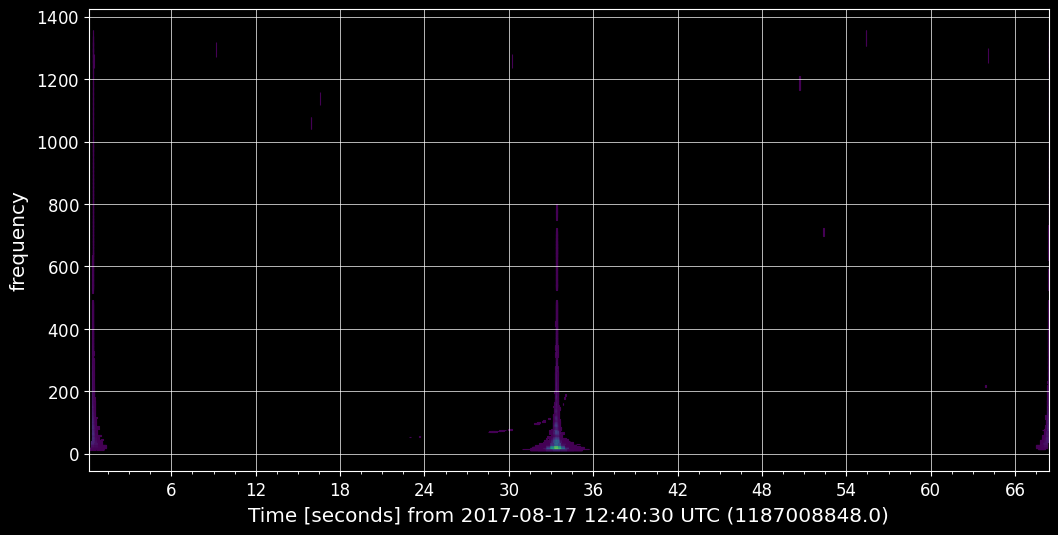

In [228]:
plotTile = segmentData.tile(
    "time",
    "frequency",
    "duration",
    "bandwidth",
    color="energy"
)

**the trace of a binary neutron star merger, sweeping up in frequency through a loud saturation glitch in the foreground**

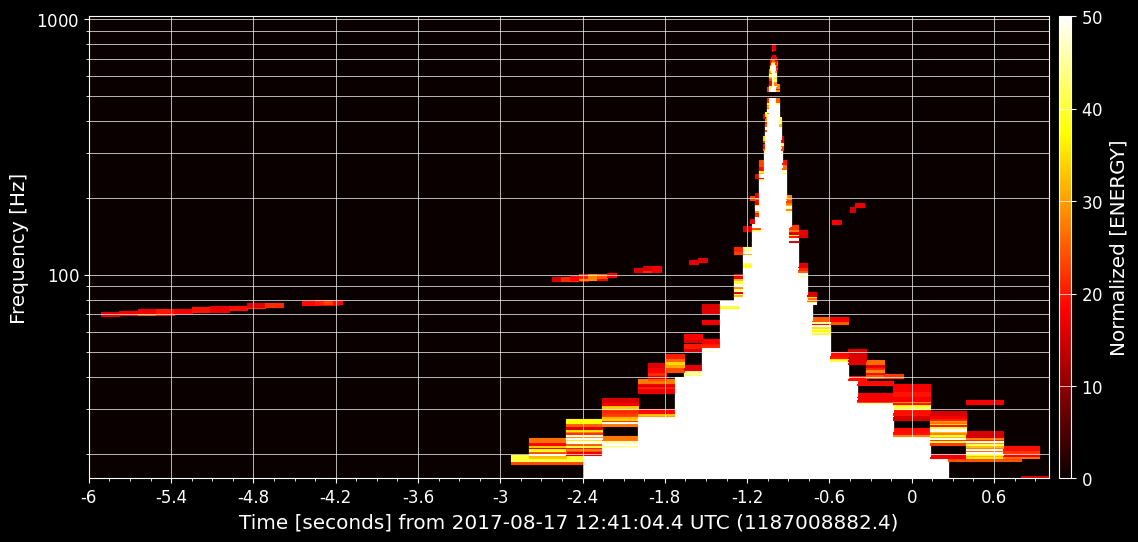

In [231]:
plotTile = segmentData.tile(
    "time",
    "frequency",
    "duration",
    "bandwidth",
    color="energy"
)
ax = plotTile.gca()
ax.set_xscale("seconds")
ax.set_xlim(GPSGW-6,GPSGW+1)
ax.set_epoch(GPSGW)
ax.set_yscale("log")
ax.set_ylim(16,1024)
ax.set_ylabel("Frequency [Hz]")
ax.grid(True,axis="y",which="both")
cmap = colormaps["hot"]
ax.colorbar(cmap=cmap,label="Normalized [ENERGY]",clim=[0,50])
ax.set_facecolor(cmap(0))
plotTile.show()